Dependencies:
tensorflow: 2.8.0

In [ ]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

In [ ]:
from google.colab import drive
!pip install ultralytics
drive.mount('/content/drive')

import tensorflow_datasets as tfds
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np


In [ ]:
!ls '/content/drive/MyDrive/fashionGAN/images'

In [ ]:
DATA_DIR = '/content/drive/MyDrive/fashionGAN/images'

In [ ]:
dataset = tfds.load('fashion_mnist', split='train')

In [ ]:
dataiterator = dataset.as_numpy_iterator()

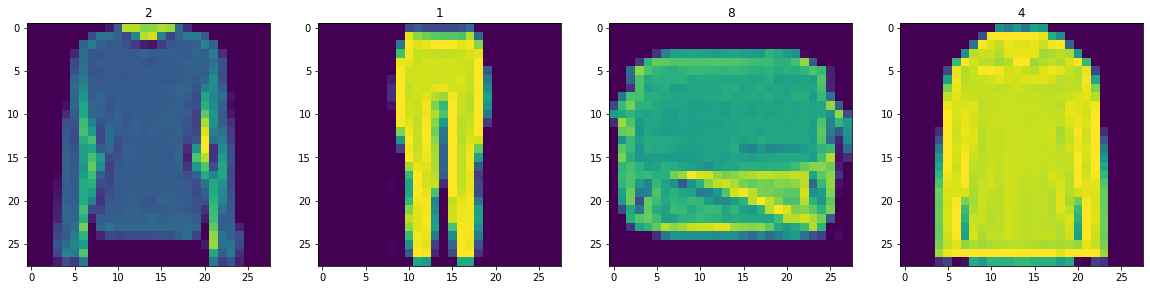

In [ ]:
fig, axis = plt.subplots(ncols = 4, figsize = (20,20))
for i in range(5):
  batch = dataiterator.next()

  axis[i].imshow(np.squeeze(batch['Image']))
  axis[i].title.set_text(batch['Label'])

In [ ]:
def scale_images(data):
    image = data['Image']
    return image / 255

In [ ]:
# Preprocessing and caching the dataset
dataset = tfds.load('fashion_mnist', split='train')
dataset = dataset.map(scale_images)
dataset = dataset.cache()
dataset = dataset.shuffle(30000)
dataset = dataset.batch(128)
dataset = dataset.prefetch(64)

In [ ]:
dataset.as_numpy_iterator().next().shape

(128, 28, 28, 1)

a) Generator:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [ ]:
def generatorBuilder:
    gseq = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    gseq.add(Dense(7*7*128, input_dim=128))
    gseq.add(LeakyReLU(0.2))
    gseq.add(Reshape((7,7,128)))

    # Upsampling block 1
    gseq.add(UpSampling2D())
    gseq.add(Conv2D(128, 5, padding='same'))
    gseq.add(LeakyReLU(0.2))

    # Upsampling block 2
    gseq.add(UpSampling2D())
    gseq.add(Conv2D(128, 5, padding='same'))
    gseq.add(LeakyReLU(0.2))

    # Convolutional block 1
    gseq.add(Conv2D(128, 4, padding='same'))
    gseq.add(LeakyReLU(0.2))

    # Convolutional block 2
    gseq.add(Conv2D(128, 4, padding='same'))
    gseq.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    gseq.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return gseq

In [ ]:
generator = generatorBuilder()

In [ ]:
generator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 6272)              809088    
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_10 (UpSampli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                     

In [ ]:
image = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 148ms/step


In [ ]:
image.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 21ms/step


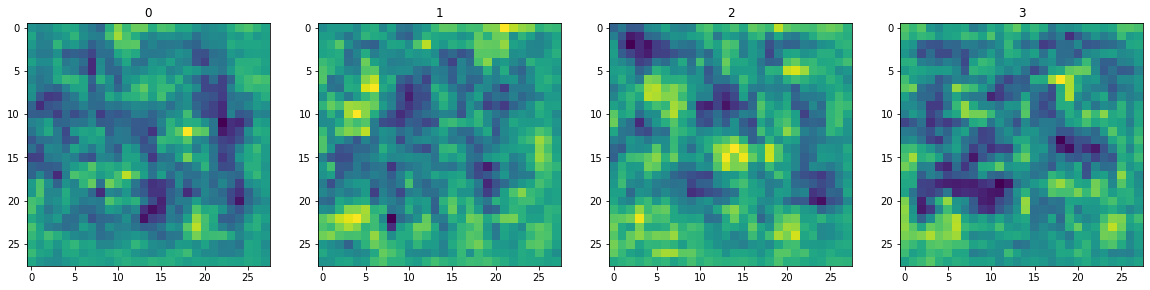

In [ ]:
image = generator.predict(np.random.randn(4,128,1))
fig, axis = plt.subplots(ncols=4, figsize=(20,20))

for i, image in enumerate(image):
    axis[i].imshow(np.squeeze(image))
    axis[i].title.set_text(i)

b) Discriminator:

In [ ]:
def discriminatorBuilder():
    seqD = Sequential()

    # First Conv Block
    seqD.add(Conv2D(32, 5, input_shape = (28,28,1)))
    seqD.add(LeakyReLU(0.2))
    seqD.add(Dropout(0.4))

    # Second Conv Block
    seqD.add(Conv2D(64, 5))
    seqD.add(LeakyReLU(0.2))
    seqD.add(Dropout(0.4))

    # Third Conv Block
    seqD.add(Conv2D(128, 5))
    seqD.add(LeakyReLU(0.2))
    seqD.add(Dropout(0.4))

    # Fourth Conv Block
    seqD.add(Conv2D(256, 5))
    seqD.add(LeakyReLU(0.2))
    seqD.add(Dropout(0.4))

    # Flatten then pass to dense layer
    seqD.add(Flatten())
    seqD.add(Dropout(0.4))
    seqD.add(Dense(1, activation='sigmoid'))

    return seqD

In [ ]:
discriminator = discriminatorBuilder()

In [ ]:
discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_20 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_21 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 128)      

In [ ]:
image.shape

(28, 28, 1)

In [ ]:
image = image[0]
#dont run this, we want to keep the img.shape at (4,28,28,1)

In [ ]:
image.shape

(4, 28, 28, 1)

In [ ]:
discriminator.predict(img)

1/1 [==============================] - 0s 475ms/step


array([[0.49068445],
       [0.4905256 ],
       [0.49058494],
       [0.49073038]], dtype=float32)

In [ ]:
#Training Loop

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model

In [ ]:
generator_opt = Adam(learning_rate=0.0001)
discriminator_opt = Adam(learning_rate=0.00001)

generator_loss = BinaryCrossentropy()
discriminator_loss = BinaryCrossentropy()

In [ ]:
class GAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator


  def compile(self, generator_opt, discriminator_opt, generator_loss, discriminator_loss, *args, **kwargs):
    super().compile(*args, **kwargs)
    self.generator_opt = generator_opt
    self.discriminator_opt = discriminator_opt
    self.generator_loss = generator_loss
    self.discriminator_loss = discriminator_loss
    pass
  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)), training = False)

    #TRAINING

    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      #real images = 0
      #fake images = 1

      realorfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      real_noise = 0.15*tf.random.uniform(tf.shape(yhat_real))
      fake_noise = -0.15*tf.random.uniform(tf.shape(yhat_fake))

      realorfake += tf.concat([real_noise, fake_noise], axis=0) #this noise is added in an effort to confuse the discriminator to make it more accurate later


      total_d_loss = self.discriminator_loss(realorfake, yhat_realfake)  #calculating loss function

      #backpropgation- dgrad = gradiant
      dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
      self.discriminator_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

      with tf.GradientTape() as g_tape:
        gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
        predicted_labels = self.discriminator(gen_images, training=False)
        total_g_loss = self.generator_loss(tf.zeros_like(predicted_labels), predicted_labels) #calculates Loss function

      # Backpropogation
      ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
      self.generator_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

      return {"Discriminator Loss":total_d_loss, "Generator Loss":total_g_loss}

      #we are generating fake images so we are rewarding generator for faking out the discriminator


In [ ]:
fashionGAN = GAN(generator, discriminator,)

In [ ]:
fashionGAN.compile(generator_opt, discriminator_opt, generator_loss, discriminator_loss)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, img_num=3, latent_dimension=128):
        self.img_num = img_num
        self.latent_dimension = latent_dimension



    def end_of_epoch(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.img_num, self.latent_dimension,1))

        generated = self.model.generator(random_latent_vectors)
        generated *= 255
        generated.numpy()
        for i in range(self.img_num):
            img = array_to_img(generated[i])
            img.save(os.path.join(DATA_DIR, f'generated{epoch}_{i}.png'))

In [ ]:
# Because of personal GPU limitation only 115 epochs could be run without crashing. But for a strong machine, use > 2000 epochs so the images will come out more accurate

hist = fashionGAN.fit(dataset, epochs = 200, callbacks=[ModelMonitor()])

Epoch 1/500
  6/469 [..............................] - ETA: 1:12 - d_loss: 0.7130 - g_loss: 0.6277

469/469 [==============================] - 75s 160ms/step - d_loss: 0.6916 - g_loss: 0.6555
Epoch 2/500
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6951 - g_loss: 0.6483
Epoch 3/500
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6778 - g_loss: 0.6585
Epoch 4/500
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6946 - g_loss: 0.6416
Epoch 5/500
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6662 - g_loss: 0.6760
Epoch 6/500
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6969 - g_loss: 0.6286
Epoch 7/500
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6870 - g_loss: 0.6478
Epoch 8/500
469/469 [==============================] - 77s 165ms/step - d_loss: 0.6922 - g_loss: 0.6514
Epoch 9/500
469/469 [==============================] - 77s 164ms/step - d_loss: 0.6727 - g_loss: 0.6725
Epoch 10/500
469/469 [==============================] - 77s 165ms/step - d_l

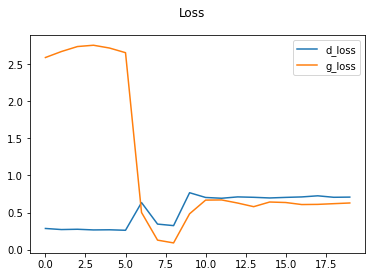

In [ ]:
#Performance

plt.suptitle('Loss Function')
plt.plot(hist.history['Discriminator loss'], label='d_loss')
plt.plot(hist.history['Generator Loss'], label='g_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 19ms/step


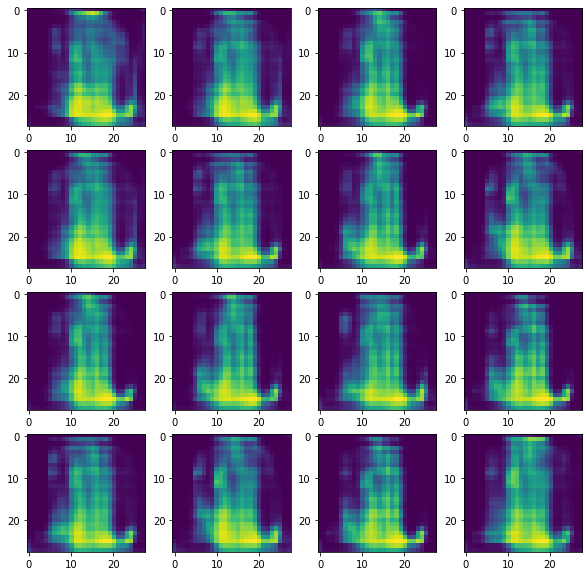

In [ ]:
#Generate fake images

image = generator.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))

for i in range(4):
    for f in range(4):
        ax[i][f].imshow(image[(i+1)*(f+1)-1])